In [30]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import os

import tensorflow as tf
import json
import time

import gymnasium as gym

## Implementing Q-Learning

In [31]:
from __future__ import annotations

from collections import defaultdict

import numpy as np
from enum import Enum
import os
import json


np.random.seed(10)

class ControlType(Enum):
    MONTE_CARLO = 1
    TEMPORAL_DIFFERENCE = 2
    Q_LEARNING = 3
    DOUBLE_Q_LEARNING = 4

class CartPoleAgent():
    def __init__(
            self,
            control_type: ControlType,
            learning_rate: float,
            initial_epsilon: float,
            epsilon_decay: float,
            final_epsilon: float,
            discount_factor: float = 0.95,
    ):
        """
        Initialize the Blackjack Agent.

        Args:
            control_type (ControlType): The control type for the agent.
            learning_rate (float): The learning rate for updating Q-values.
            initial_epsilon (float): The initial exploration rate.
            epsilon_decay (float): The rate at which epsilon decays over time.
            final_epsilon (float): The final exploration rate.
            discount_factor (float, optional): The discount factor for future rewards. Defaults to 0.95.
        """
        self.control_type = control_type
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.num_of_action = 2
        self.q_values = defaultdict(lambda: np.zeros(self.num_of_action))
        self.n_values = defaultdict(lambda: np.zeros(self.num_of_action))
        self.training_error = []

        if self.control_type == ControlType.MONTE_CARLO:
            self.obs_hist = []
            self.action_hist = []
            self.reward_hist = []
        elif self.control_type == ControlType.DOUBLE_Q_LEARNING:
            self.qa_values = defaultdict(lambda: np.zeros(self.num_of_action))
            self.qb_values = defaultdict(lambda: np.zeros(self.num_of_action))

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Get action based on epsilon-greedy policy.

        Args:
            obs (tuple[int, int, bool]): The observation state.

        Returns:
            int: The chosen action.
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.num_of_action)
        else:
            return int(np.argmax(self.q_values[obs]))

    def __Q_Learning_Update__(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        next_obs: tuple[int, int, bool],
        terminated: bool
    ):
        """
        Update Q-values using Q-Learning.

        Args:
            obs (tuple[int, int, bool]): Current observation state.
            action (int): Action taken.
            reward (float): Reward received.
            next_obs (tuple[int, int, bool]): Next observation state.
            terminated (bool): Whether the episode terminated.
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def __Double_Q_Learning_Update__(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        next_obs: tuple[int, int, bool],
        terminated: bool
    ):
        """
        Update Q-values using Double Q-Learning.

        Args:
            obs (tuple[int, int, bool]): Current observation state.
            action (int): Action taken.
            reward (float): Reward received.
            next_obs (tuple[int, int, bool]): Next observation state.
            terminated (bool): Whether the episode terminated.
        """
        if np.random.uniform(0, 1) < 0.5:
            max_next_action = np.argmax(self.qb_values[next_obs])
            future_q_value = (not terminated) * self.qa_values[next_obs][max_next_action]
            temporal_difference = (
                reward + self.discount_factor * future_q_value - self.qb_values[obs][action]
            )
            self.qb_values[obs][action] = (
                self.qb_values[obs][action] + self.lr * temporal_difference
            )
            self.training_error.append(temporal_difference)
        else:
            max_next_action = np.argmax(self.qa_values[next_obs])
            future_q_value = (not terminated) * self.qb_values[next_obs][max_next_action]
            temporal_difference = (
                reward + self.discount_factor * future_q_value - self.qa_values[obs][action]
            )
            self.qa_values[obs][action] = (
                self.qa_values[obs][action] + self.lr * temporal_difference
            )
            self.training_error.append(temporal_difference)
        for i in range(self.num_of_action):
            self.q_values[obs][i] = (self.qa_values[obs][i] + self.qb_values[obs][i]) / 2

    def __Monte_Carlo_Update__(
        self,
        obs: tuple[int, int, int, int],
        action: int,
        reward: float,
        terminated: bool
    ):
        """
        Update Q-values using Monte Carlo method.

        Args:
            obs (tuple[int, int, bool]): Current observation state.
            action (int): Action taken.
            reward (float): Reward received.
            terminated (bool): Whether the episode terminated.
        """
        self.obs_hist.append(obs)
        self.action_hist.append(action)
        self.reward_hist.append(reward)
        if terminated:
            Gt = 0.0
            error_list = []
            for i in reversed(range(len(self.reward_hist))):
                Gt = (self.discount_factor * Gt) + float(self.reward_hist[i])
                self.n_values[self.obs_hist[i]][self.action_hist[i]] += 1.0
                lr = 1.0 / self.n_values[self.obs_hist[i]][self.action_hist[i]]
                temporal_difference = (
                    Gt - self.q_values[self.obs_hist[i]][self.action_hist[i]]
                )
                self.q_values[self.obs_hist[i]][self.action_hist[i]] += (lr * temporal_difference)
                # error_list.insert(0, temporal_difference)
            # self.training_error.extend(error_list.copy())
            self.obs_hist.clear()
            self.action_hist.clear()
            self.reward_hist.clear()

    def __Temporal_Difference_Update__(
        self,
        obs: tuple[int, int, int, int],
        action: int,
        reward: float,
        next_obs: tuple[int, int, int, int],
        next_action: int,
        terminated: bool,
    ):
        """
        Update Q-values using Temporal Difference learning.

        Args:
            obs (tuple[int, int, bool]): Current observation state.
            action (int): Action taken.
            reward (float): Reward received.
            next_obs (tuple[int, int, bool]): Next observation state.
            next_action (int): Action to be taken in the next state.
            terminated (bool): Whether the episode terminated.
        """
        future_q_value = (not terminated) * self.q_values[next_obs][next_action]
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)
        
    def update(
        self,
        obs: tuple[int, int, int, int] = (0, 0, 0, 0),
        action: int = 0,
        reward: float = 0.0,
        next_obs: tuple[int, int, int, int] = (0, 0, 0, 0),
        next_action: int = 0,
        terminated: bool = False,
    ):
        """
        Update the agent's Q-values based on the control type.

        Args:
            obs (tuple[int, int, bool], optional): Current observation state. Defaults to (0, 0, False).
            action (int, optional): Action taken. Defaults to 0.
            reward (float, optional): Reward received. Defaults to 0.0.
            next_obs (tuple[int, int, bool], optional): Next observation state. Defaults to (0, 0, False).
            next_action (int, optional): Action to be taken in the next state. Defaults to 0.
            terminated (bool, optional): Whether the episode terminated. Defaults to False.
        """
        if self.control_type == ControlType.Q_LEARNING:
            self.__Q_Learning_Update__(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )
        elif self.control_type == ControlType.MONTE_CARLO:
            self.__Monte_Carlo_Update__(
                obs=obs,
                action=action,
                reward=reward,
                terminated=terminated
            )
        elif self.control_type == ControlType.TEMPORAL_DIFFERENCE:
            self.__Temporal_Difference_Update__(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                next_action=next_action,
                terminated=terminated
            )
        elif self.control_type == ControlType.DOUBLE_Q_LEARNING:
            self.__Double_Q_Learning_Update__(
                obs=obs,
                action=action,
                reward=reward,
                next_obs=next_obs,
                terminated=terminated
            )

    def decay_epsilon(self):
        """
        Decay epsilon value.
        """
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def save_model(self, path, filename):
        """
        Save the model parameters to a JSON file.

        Args:
            path (str): Path to save the model.
            filename (str): Name of the file.
        """
        # Convert tuple keys to strings
        try:
            q_values_str_keys = {str(k): v.tolist() for k, v in self.q_values.items()}
        except:
            q_values_str_keys = {str(k): v for k, v in self.q_values.items()}
        if self.control_type == ControlType.MONTE_CARLO:
            try:
                n_values_str_keys = {str(k): v.tolist() for k, v in self.n_values.items()}
            except:
                n_values_str_keys = {str(k): v for k, v in self.n_values.items()}
        
        # Save model parameters to a JSON file
        if self.control_type == ControlType.MONTE_CARLO:
            model_params = {
                'q_values': q_values_str_keys,
                'n_values': n_values_str_keys
            }
        else:
            model_params = {
                'q_values': q_values_str_keys,
            }
        full_path = os.path.join(path, filename)
        with open(full_path, 'w') as f:
            json.dump(model_params, f)

            
    def load_model(self, path, filename):
        """
        Load model parameters from a JSON file.

        Args:
            path (str): Path where the model is stored.
            filename (str): Name of the file.

        Returns:
            dict: The loaded Q-values.
        """
        full_path = os.path.join(path, filename)
        # try:         
        with open(full_path, 'r') as file:
            data = json.load(file)
            data_q_values = data['q_values']
            for state, action_values in data_q_values.items():
                state = state.replace('(', '')
                state = state.replace(')', '')
                tuple_state = tuple(map(float, state.split(', ')))
                self.q_values[tuple_state] = action_values.copy()
                if self.control_type == ControlType.DOUBLE_Q_LEARNING:
                    self.qa_values[tuple_state] = action_values.copy()
                    self.qb_values[tuple_state] = action_values.copy()
            if self.control_type == ControlType.MONTE_CARLO:
                data_n_values = data['n_values']
                for state, n_values in data_n_values.items():
                    state = state.replace('(', '')
                    state = state.replace(')', '')
                    tuple_state = tuple(map(float, state.split(', ')))
                    self.n_values[tuple_state] = n_values.copy()
            return self.q_values
        # except:
        #     print("error")
        #     pass

## Train RL Model

### Q-Learning

In [32]:
environment_name = 'CartPole-v1'
Algorithm_name = "Q_Learning"

# reward_function = "Sparse"
# reward_function = "Differentiation"
reward_function = "Absolute"

# env = gym.make(environment_name, render_mode="human", observation_type = "Discrete", reward_function = reward_function)
env = gym.make(environment_name, observation_type = "Discrete", reward_function = reward_function)

In [33]:
# hyperparameters
learning_rate = 0.01
n_episodes = 50000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.95

control_type = ControlType.Q_LEARNING

agent = CartPoleAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

In [34]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

dis_play_list =[]
error_list = []

# N = defaultdict(lambda: np.zeros(1))
return_sum = defaultdict(lambda: np.zeros(env.action_space.n))

error_pole_pos_np_min = defaultdict(lambda: 0)
error_pole_pos_np_max = defaultdict(lambda: 0)
avg_error_pole_pos_dict = defaultdict(lambda: 0)

error_cart_pos_np_min = defaultdict(lambda: 0)
error_cart_pos_np_max = defaultdict(lambda: 0)
avg_error_cart_pos_dict = defaultdict(lambda: 0)

episode_scores_dict = defaultdict(lambda: 0)

N_dict = defaultdict(lambda: 0)
iteration = 0

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    score = 0
    # discrete_state = (0, 0, 0, 0)
    # next_discrete_state = [0, 0, 0, 0]
    prev_time = 0
    targetAngle = 0
    history_ls = []

    # discrete_state = map_discrete_state(obs)
    time_step = 0

    iteration += 1

    prev_agent_pos = 0

    top_botom_penalty = 0

    # play one episode
    while not done:
        env.render()
        # Choose a from s using policy derived from Q
        action = agent.get_action(tuple(obs))
        # action = agent.get_action(discrete_state)
        next_obs, reward, terminated, truncated, info = env.step(action)
        # next_discrete_state = map_discrete_state(next_obs)
        score += reward

        delta_time = 0
        # discrete_reward, error_cart_pos, error_pole_pos, prev_agent_pos, top_botom_penalty = reward_function(next_discrete_state, score, delta_time, targetAngle, prev_agent_pos, terminated, top_botom_penalty)
        time_step += 1
        # error_pole_pos_np[iteration - 1][time_step - 1] = error_pole_pos

        error_cart_pos = abs(next_obs[0])

        error_pole_pos = abs(next_obs[2])

        if error_cart_pos >= error_cart_pos_np_max[time_step - 1]:
            error_cart_pos_np_max[time_step - 1] = error_cart_pos
        elif error_cart_pos <= error_cart_pos_np_min[time_step - 1]:
            error_cart_pos_np_min[time_step - 1] = error_cart_pos

        if error_pole_pos >= error_pole_pos_np_max[time_step - 1]:
            error_pole_pos_np_max[time_step - 1] = error_pole_pos
        elif error_pole_pos <= error_pole_pos_np_min[time_step - 1]:
            error_pole_pos_np_min[time_step - 1] = error_pole_pos

        N_dict[time_step - 1] += 1
        avg_error_cart_pos_dict[time_step - 1] = avg_error_cart_pos_dict[time_step - 1] + (error_cart_pos - avg_error_cart_pos_dict[time_step - 1]) / N_dict[time_step - 1]
        avg_error_pole_pos_dict[time_step - 1] = avg_error_pole_pos_dict[time_step - 1] + (error_pole_pos - avg_error_pole_pos_dict[time_step - 1]) / N_dict[time_step - 1]
        
        agent.update(
            obs=tuple(obs),
            action=action,
            reward=reward,
            terminated=terminated
        )
        
        # update if the environment is done and the current obs
        done = terminated or truncated     
        # discrete_state = next_discrete_state
        obs = next_obs

    episode_scores_dict[episode] = score

    dis_play_list.append(score)
    agent.decay_epsilon()

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [01:11<00:00, 695.38it/s]


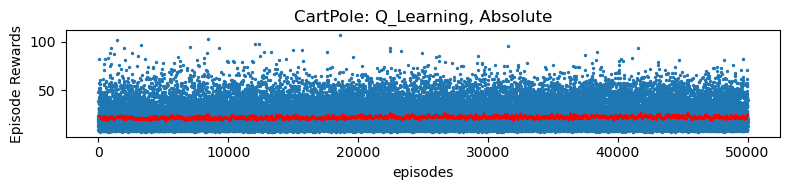

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming episode_scores_dict is already defined
episode_scores = [array for array in episode_scores_dict.values()]
x = np.linspace(1, len(episode_scores), len(episode_scores))

# Define the window size for the rolling mean
EPISODES_WINDOW = 100  # You can adjust the window size as needed

# Function to compute the rolling mean
def window_func(x, y, window_size, func):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    y_mean = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    x_mean = x[window_size - 1:]
    return x_mean, y_mean

# Plotting
title = "CartPole: {}, {}".format(Algorithm_name, reward_function)
figsize = (8, 2)
plt.figure(title, figsize=figsize) 
plt.scatter(x, episode_scores, s=2)

# Compute and plot rolling mean if the time series is long enough
if len(x) >= EPISODES_WINDOW:
    x_mean, y_mean = window_func(x, episode_scores, EPISODES_WINDOW, np.mean)
    plt.plot(x_mean, y_mean, color='red')

plt.title(title)
plt.xlabel("episodes")
plt.ylabel("Episode Rewards")
plt.tight_layout()
plt.show()


In [36]:
#Save Q-Learning agent
q_value_file = "Q_Learning_cart_pole_50000.json"
full_path = os.path.join("q_value", Algorithm_name, reward_function)
agent.save_model(full_path, q_value_file)

# Testing

In [37]:
# env = gym.make(environment_name, render_mode="human", observation_type = "Discrete", reward_function = reward_function)
env = gym.make(environment_name, observation_type = "Discrete", reward_function = reward_function)

In [38]:
#Load MC Agent

# hyperparameters
learning_rate = 0.01
n_episodes = 500
start_epsilon = 0.001
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.001
discount = 0.01

control_type = ControlType.Q_LEARNING

agent = CartPoleAgent(
    control_type=control_type,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor=discount
)

In [39]:
q_value_file = "Q_Learning_cart_pole_50000.json"
full_path = os.path.join("q_value", Algorithm_name, reward_function)
agent.load_model(full_path, q_value_file)

defaultdict(<function __main__.CartPoleAgent.__init__.<locals>.<lambda>()>,
            {(0.0, 0.0, 0.0, 0.0): [4.30878497421627, 11.498650845406514],
             (0.0, 0.0, -42.0, 0.0): [2.6839150164921075, 11.204791676929188],
             (0.0, 0.0, -42.0, 2.0): [8.774897459886612, 1.3940265504895004],
             (0.0, 0.0, -37.0, 0.0): [2.937570823546505, 11.391531958489887],
             (0.0, 0.0, -37.0, -3.0): [2.121617882716241, 10.189397150521732],
             (0.0, 0.0, -44.0, -6.0): [1.4671458341835093, 9.295616632833976],
             (0.0, 0.0, -57.0, -3.0): [1.556401599196579, 10.009625791947354],
             (0.0, 0.0, -64.0, 0.0): [6.247016435237483, 1.0232989595579571],
             (0.0, 0.0, -66.0, 1.0): [5.73724863792412, 0.48100221335383764],
             (0.0, 0.0, -62.0, 4.0): [7.154394923270733, 0.4488832079999075],
             (0.0, 0.0, -53.0, 7.0): [0.2805363196389298, 5.100762710015387],
             (0.0, 0.0, -39.0, 9.0): [0.07989994236571893, 0.7404

In [40]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

dis_play_list =[]
error_list = []

# N = defaultdict(lambda: np.zeros(1))
return_sum = defaultdict(lambda: np.zeros(env.action_space.n))

pole_pos_np_min = defaultdict(lambda: 0)
pole_pos_np_max = defaultdict(lambda: 0)
avg_error_pole_pos_dict = defaultdict(lambda: 0)

cart_pos_np_min = defaultdict(lambda: 0)
cart_pos_np_max = defaultdict(lambda: 0)
avg_error_cart_pos_dict = defaultdict(lambda: 0)

pole_vel_np_min = defaultdict(lambda: 0)
pole_vel_np_max = defaultdict(lambda: 0)
avg_error_pole_vel_dict = defaultdict(lambda: 0)

cart_vel_np_min = defaultdict(lambda: 0)
cart_vel_np_max = defaultdict(lambda: 0)
avg_error_cart_vel_dict = defaultdict(lambda: 0)

N_pos_dict = defaultdict(lambda: 0)
N_vel_dict = defaultdict(lambda: 0)

avg_reward = 0
avg_reward_per_epdisode =  []

iteration = 0

sum_reward = 0

sum_time_steps = 0
avg_time_steps = 0

successrate = 0
successrate_count = 0

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    score = 0
    # discrete_state = (0, 0, 0, 0)
    # next_discrete_state = [0, 0, 0, 0]
    prev_time = 0
    targetAngle = 0
    history_ls = []

    # discrete_state = map_discrete_state(obs)
    time_step = 0

    iteration += 1

    prev_agent_pos = 0

    top_botom_penalty = 0

    # play one episode
    while not done:
        env.render()
        # Choose a from s using policy derived from Q
        action = agent.get_action(tuple(obs))
        # action = agent.get_action(discrete_state)
        next_obs, reward, terminated, truncated, info = env.step(action)
        # next_discrete_state = map_discrete_state(next_obs)

        cart_pos = obs[0]
        cart_vel = obs[1]
        pole_pos = obs[2]
        pole_vel = obs[3]

        score += reward

        delta_time = 0
        # discrete_reward, error_cart_pos, error_pole_pos, prev_agent_pos, top_botom_penalty = reward_function(next_discrete_state, score, delta_time, targetAngle, prev_agent_pos, terminated, top_botom_penalty)
        time_step += 1
        # error_pole_pos_np[iteration - 1][time_step - 1] = error_pole_pos

        if cart_pos >= cart_pos_np_max[time_step - 1]:
            cart_pos_np_max[time_step - 1] = cart_pos
        if cart_pos <= cart_pos_np_min[time_step - 1]:
            cart_pos_np_min[time_step - 1] = cart_pos

        if pole_pos >= pole_pos_np_max[time_step - 1]:
            pole_pos_np_max[time_step - 1] = pole_pos
        if pole_pos <= pole_pos_np_min[time_step - 1]:
            pole_pos_np_min[time_step - 1] = pole_pos

        N_pos_dict[time_step - 1] += 1
        avg_error_cart_pos_dict[time_step - 1] = avg_error_cart_pos_dict[time_step - 1] + (cart_pos - avg_error_cart_pos_dict[time_step - 1]) / N_pos_dict[time_step - 1]
        avg_error_pole_pos_dict[time_step - 1] = avg_error_pole_pos_dict[time_step - 1] + (pole_pos - avg_error_pole_pos_dict[time_step - 1]) / N_pos_dict[time_step - 1]

        if cart_vel >= cart_vel_np_max[time_step - 1]:
            cart_vel_np_max[time_step - 1] = cart_vel
        if cart_vel <= cart_vel_np_min[time_step - 1]:
            cart_vel_np_min[time_step - 1] = cart_vel

        if pole_vel >= pole_vel_np_max[time_step - 1]:
            pole_vel_np_max[time_step - 1] = pole_vel
        if pole_vel <= pole_vel_np_min[time_step - 1]:
            pole_vel_np_min[time_step - 1] = pole_vel

        N_vel_dict[time_step - 1] += 1
        avg_error_cart_vel_dict[time_step - 1] = avg_error_cart_vel_dict[time_step - 1] + (cart_vel - avg_error_cart_vel_dict[time_step - 1]) / N_vel_dict[time_step - 1]
        avg_error_pole_vel_dict[time_step - 1] = avg_error_pole_vel_dict[time_step - 1] + (pole_vel - avg_error_pole_vel_dict[time_step - 1]) / N_vel_dict[time_step - 1]

        # update if the environment is done and the current obs
        done = terminated or truncated     
        # discrete_state = next_discrete_state
        obs = next_obs

    sum_reward += score

    sum_time_steps += time_step

    if time_step == 500:
        successrate_count += 1

    # print(time_step)
    dis_play_list.append(score)
    agent.decay_epsilon()

avg_time_steps = sum_time_steps/n_episodes
avg_reward = sum_reward/n_episodes
successrate = successrate_count/n_episodes * 100

print("Average Rewards: ", avg_reward)
print("Average Time Steps: ", avg_time_steps)
print("Successrate: ", successrate)

100%|██████████| 500/500 [00:00<00:00, 609.55it/s]

Average Rewards:  23.172153683407597
Average Time Steps:  24.254
Successrate:  0.0


### Graph: Avg.Pole Position and Velocity vs Time steps [Testing] 

stabilized_index_pos:  0
Minimum value in stabilized region: -0.209
Maximum value in stabilized region: 0.209


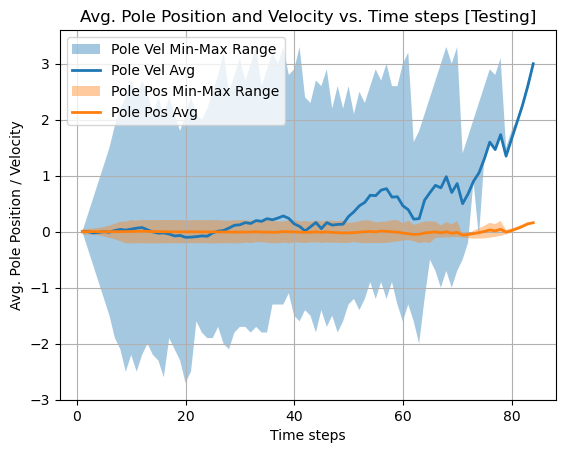

In [41]:
# Replace 0s in pole_pos_np_min and pole_pos_np_max with values from avg_error_pole_pos_dict
for i in range(len(pole_pos_np_min)):
    if pole_pos_np_min[i] == 0:
        pole_pos_np_min[i] = avg_error_pole_pos_dict[i]
    if pole_pos_np_max[i] == 0:
        pole_pos_np_max[i] = avg_error_pole_pos_dict[i]

# Replace 0s in pole_vel_np_min and pole_vel_np_max with values from avg_error_pole_vel_dict
for i in range(len(pole_vel_np_min)):
    if pole_vel_np_min[i] == 0:
        pole_vel_np_min[i] = avg_error_pole_vel_dict[i]
    if pole_vel_np_max[i] == 0:
        pole_vel_np_max[i] = avg_error_pole_vel_dict[i]

# Plotting pole position
fig, ax = plt.subplots()


# Plotting pole velocity
y_vel_min = [array/10 for array in pole_vel_np_min.values()]
y_vel_max = [array/10 for array in pole_vel_np_max.values()]
y_vel_avg = [array/10 for array in avg_error_pole_vel_dict.values()]

x = np.linspace(1, len(y_vel_avg), len(y_vel_avg))

# Plot min-max range for pole velocity
ax.fill_between(x, y_vel_min, y_vel_max, alpha=.4, linewidth=0, label='Pole Vel Min-Max Range')

# Plot average error for pole velocity
ax.plot(x, y_vel_avg, linewidth=2, label='Pole Vel Avg')

y_pos_min = [array/1000 for array in pole_pos_np_min.values()]
y_pos_max = [array/1000 for array in pole_pos_np_max.values()]
y_pos_avg = [array/1000 for array in avg_error_pole_pos_dict.values()]

# Plot min-max range for pole position
ax.fill_between(x, y_pos_min, y_pos_max, alpha=.4, linewidth=0, label='Pole Pos Min-Max Range')

# Plot average error for pole position
ax.plot(x, y_pos_avg, linewidth=2, label='Pole Pos Avg')

# Find the index where y_avg is near 0 (stabilized) for pole position
stabilized_index_pos = np.where(np.abs(y_pos_avg) < 0.008)[0]


# Plot dashed line for stabilized region and change its color to red
if len(stabilized_index_pos) > 0:
    print("stabilized_index_pos: ", stabilized_index_pos[0])
    start_stable = stabilized_index_pos[0]
    end_stable = stabilized_index_pos[-1]
    stabilized_y_min = min(y_pos_min[start_stable:end_stable+1])
    stabilized_y_max = max(y_pos_max[start_stable:end_stable+1])
    print("Minimum value in stabilized region:", stabilized_y_min)
    print("Maximum value in stabilized region:", stabilized_y_max)

    start_stable = stabilized_index_pos[0]
    end_stable = stabilized_index_pos[-1]
    # ax.plot(x[start_stable:end_stable+1], y_pos_avg[start_stable:end_stable+1], 'r--', linewidth=2, label='Stabilized Region')

    # Plot markers for stabilized time steps
    # ax.plot(x[start_stable], y_pos_avg[start_stable], 'ro', markersize=6, label='Stabilized Time Steps')


# Set grid
ax.grid(True)

# Add title and labels
ax.set_title('Avg. Pole Position and Velocity vs. Time steps [Testing]')
ax.set_xlabel('Time steps')
ax.set_ylabel('Avg. Pole Position / Velocity')

# Add legend
ax.legend()

plt.show()

stabilized_index_cart:  0
Minimum value in stabilized region: -0.7
Maximum value in stabilized region: 0.4


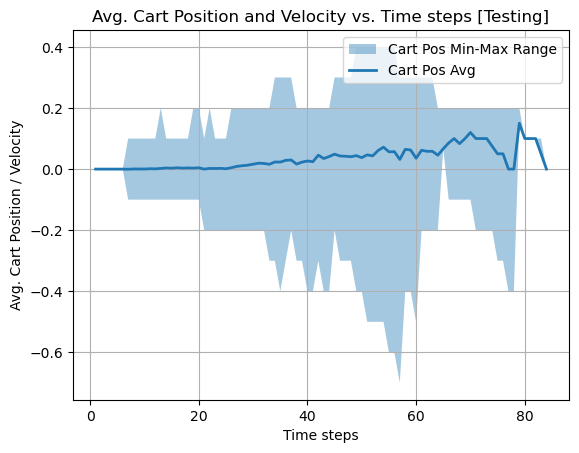

In [42]:
# Replace 0s in pole_pos_np_min and pole_pos_np_max with values from avg_error_pole_pos_dict
for i in range(len(cart_pos_np_min)):
    if cart_pos_np_min[i] == 0:
        cart_pos_np_min[i] = avg_error_cart_pos_dict[i]
    if pole_pos_np_max[i] == 0:
        cart_pos_np_max[i] = avg_error_cart_pos_dict[i]

# Replace 0s in pole_vel_np_min and pole_vel_np_max with values from avg_error_pole_vel_dict
for i in range(len(cart_vel_np_min)):
    if cart_vel_np_min[i] == 0:
        cart_vel_np_min[i] = avg_error_cart_vel_dict[i]
    if cart_vel_np_max[i] == 0:
        cart_vel_np_max[i] = avg_error_cart_vel_dict[i]

# Plotting pole position
fig, ax = plt.subplots()


# Plotting pole velocity
y_vel_min = [array for array in cart_vel_np_min.values()]
y_vel_max = [array for array in cart_vel_np_max.values()]
y_vel_avg = [array for array in avg_error_cart_vel_dict.values()]

x = np.linspace(1, len(y_vel_avg), len(y_vel_avg))

# Plot min-max range for pole velocity
# ax.fill_between(x, y_vel_min, y_vel_max, alpha=.4, linewidth=0, label='Cart Vel Min-Max Range')

# Plot average error for pole velocity
# ax.plot(x, y_vel_avg, linewidth=2, label='Cart Vel Avg')

y_pos_min = [array/10 for array in cart_pos_np_min.values()]
y_pos_max = [array/10 for array in cart_pos_np_max.values()]
y_pos_avg = [array/10 for array in avg_error_cart_pos_dict.values()]

# Plot min-max range for pole position
ax.fill_between(x, y_pos_min, y_pos_max, alpha=.4, linewidth=0, label='Cart Pos Min-Max Range')

# Plot average error for pole position
ax.plot(x, y_pos_avg, linewidth=2, label='Cart Pos Avg')

# Find the index where y_avg is near 0 (stabilized) for pole position
stabilized_index_pos = np.where(np.abs(y_pos_avg) < 0.008)[0]
print("stabilized_index_cart: ", start_stable)

# Plot dashed line for stabilized region and change its color to red
if len(stabilized_index_pos) > 0:
    # start_stable = stabilized_index_pos[0]
    # end_stable = stabilized_index_pos[-1]
    stabilized_y_min = min(y_pos_min[start_stable:end_stable+1])
    stabilized_y_max = max(y_pos_max[start_stable:end_stable+1])
    print("Minimum value in stabilized region:", stabilized_y_min)
    print("Maximum value in stabilized region:", stabilized_y_max)

    # ax.plot(x[start_stable:end_stable+1], y_pos_avg[start_stable:end_stable+1], 'r--', linewidth=2, label='Stabilized Region')

    # Plot markers for stabilized time steps
    # ax.plot(x[start_stable], y_pos_avg[start_stable], 'ro', markersize=6, label='Stabilized Time Steps')


# Set grid
ax.grid(True)

# Add title and labels
ax.set_title('Avg. Cart Position and Velocity vs. Time steps [Testing]')
ax.set_xlabel('Time steps')
ax.set_ylabel('Avg. Cart Position / Velocity')

# Add legend
ax.legend()

plt.show()